In [40]:
import json, requests, os, re
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from pathlib import Path

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

USER_NAME = "gray_matter"
LEAGUE_NAME = 'FFL Champions League'
KTC_Value = {'sf':'sfQBValue', '1qb':'oneQBRank'}



API_BASE = "https://api.sleeper.app/v1/"
YEAR = "2021"
DRAFTING = 1

[('Die Hard Dynasty', '709838602963587072'),
 ('The Black Hole of Free Time', '711050188327849984'),
 ('Footballholics Auctioneers', '693953665865719808'),
 ('Fantasy Football Junkies', '654119835697004544'),
 ('Jimmy Rustlers Anonymous', '650074922340679680')]

def user_id(user_name):
    user_url = f"https://api.sleeper.app/v1/user/{user_name}"
    un_res = requests.get(user_url)
    user_id = un_res.json()['user_id']
    return user_id

def user_leagues(user_name:str, year= '2021') -> list:
    owner_id = user_id(user_name)
    leagues_url = f"https://api.sleeper.app/v1/user/{owner_id}/leagues/nfl/{year}"
    leagues_res = requests.get(leagues_url)
    LEAGUE_META = [(i['name'],i['league_id'], i['draft_id'] ) for i in leagues_res.json()]
    return LEAGUE_META

def league_managers(league_str: str, user_name:str) -> list:
    managers = []
    for i in user_leagues(user_name):
        if i[0] in league_str:
            LEAGUE_ID = i[1]
            league_managers_url = f"https://api.sleeper.app/v1/league/{LEAGUE_ID}/users"
            managers_res = requests.get(league_managers_url)
            for i in managers_res.json():
                a1 = (i['user_id'],i['display_name'], i['league_id'])
                managers.append(a1)
    return managers

def _get_drafted_players(draft_id:str) -> list:

    draft_url = f"https://api.sleeper.app/v1/draft/{draft_id}/picks"
    draft_req = requests.get(draft_url)
    players_drafted = [i['player_id'] for i in draft_req.json()]
    
    return players_drafted
    

In [2]:
selected_league_meta = [i for i in user_leagues(USER_NAME) if LEAGUE_NAME in i[0]]
draft_id = selected_league_meta[0][2]
drafted_players = _get_drafted_players(draft_id)

In [3]:
selected_league_meta


[('FFL Champions League', '729494494428377088', '729494495313420288')]

In [4]:
def pull_ktc_ranks():
    page = '0'
    ktc_base = f"https://keeptradecut.com/dynasty-rankings?page={page}&filters=QB|WR|RB|TE|RDP&format=1"
    res = requests.get(ktc_base)
    soup = BeautifulSoup(res.text, 'html.parser') # If this line causes an error, run 'pip install html5lib' or install html5lib
    # Get all script tags from KTC homepage
    scripts = soup.find_all('script')
    # the 6th script element contains the Players array
    script_var_array = scripts[6]
    # returning the string of the script tag for parsing
    players_script = script_var_array.contents[0]
    
    # Start parsing for the players array
    START_REGEX= 'var playersArray ='
    # second occurance of semicolin
    end_regex = ';'
    
    start_substr_num = players_script.find(START_REGEX) + len(START_REGEX) +1
    second_semicolin_num = [m.start() for m in re.finditer(r";", players_script)][1]
    
    players_array = players_script[start_substr_num:second_semicolin_num]
    
    players_json = json.loads(players_array)
    
    players_raw_df = pd.DataFrame(players_json)
    players_oneQB_df = players_raw_df.drop('oneQBValues', 1).assign(**players_raw_df.oneQBValues.dropna().apply(pd.Series))
    players_oneQB_df.rename(columns = {'value':'oneQBValue', 'rank': 'oneQBRank'}, inplace = True)
    players_preped_df = players_oneQB_df.drop('superflexValues', 1).assign(**players_oneQB_df.superflexValues.dropna().apply(pd.Series))
    players_preped_df.rename(columns = {'value':'sfQBValue', 'rank': 'sfQBRank'}, inplace = True)
    
    return players_preped_df


In [5]:
users_size = len(league_managers('Footballholics Auctioneers', USER_NAME))

In [6]:
all_players_df = pd.DataFrame() 

league_users =  [i[1] for i in league_managers(LEAGUE_NAME, USER_NAME)]

for user in league_users:
    owner_id = user_id(user)
    league_ids = user_leagues(user)
    
    LEAGUES = [i for i in league_ids]
    league_cnt = len(LEAGUES)
    
    for league in LEAGUES:

        rosters_url = f"https://api.sleeper.app/v1/league/{league[1]}/rosters"
        roster_res = requests.get(rosters_url)
        league_rosters = roster_res.json()
        
        for roster in league_rosters:
            if roster['owner_id'] == owner_id:
                roster.update({'league_id': league[1]})
                roster.update({'league_name': league[0]})
                players = roster['players']
                player_data = []
                if players:
                    for player in players:
                        player_tuple = (player, league[0], league[1], user, owner_id, league_cnt)
                        player_data.append(player_tuple)

                    player_df = pd.DataFrame(player_data, columns=['player_id', 'league_name', 'league_id', 'user_name', 'user_id', 'league_cnt'])
                    all_players_df = all_players_df.append(player_df,ignore_index=True)
ap_df = all_players_df.groupby(['player_id', 'user_name', 'user_id', 'league_cnt'],as_index = False).size()

In [7]:
league_managers(LEAGUE_NAME, USER_NAME)

[('335448039688781824', 'LueManChu', '729494494428377088'),
 ('337340168123998208', 'DaveBroooo', '729494494428377088'),
 ('341662359078580224', 'LuckyJoncas', '729494494428377088'),
 ('342397313982976000', 'Gray_Matter', '729494494428377088'),
 ('388538400170377216', 'VonH', '729494494428377088'),
 ('462083442125828096', 'andichrist', '729494494428377088'),
 ('467372269555937280', 'PutUpOrShutUpDE', '729494494428377088'),
 ('470289614557409280', 'randomzz', '729494494428377088'),
 ('607014567947599872', 'Jamesob51', '729494494428377088'),
 ('700613738675372032', 'Rg1hunnid', '729494494428377088'),
 ('725877123453136896', 'nharabadger', '729494494428377088')]

In [8]:
base_dir = os.getcwd()
data_path = Path(f"{base_dir}/data/")
players_path = data_path / "players.txt"

In [9]:
players_df = pd.read_json(players_path)

In [10]:
ap = players_df.T

In [11]:
cp = pd.merge(ap_df, ap, on='player_id')

In [12]:
cpc = cp[['user_name','player_id','position','full_name', 'league_cnt', 'size']]

In [13]:
complete_players_cnt = cpc.sort_values(by=['size'], ascending=False)

In [14]:
complete_players_cnt['user_name'] = complete_players_cnt['user_name'].str.lower()

In [15]:
ord_league_users = [USER_NAME.lower(), *[i.lower() for i in league_users if i.lower() != USER_NAME.lower()]]

In [16]:
for col in ord_league_users:
    col_calc = np.where(complete_players_cnt['user_name'] == col, complete_players_cnt['size'], 0)
    complete_players_cnt[col] = col_calc
    complete_players_cnt[f'{col}_pct'] = (complete_players_cnt[col]/complete_players_cnt['league_cnt']).round(3)
    complete_players_cnt[f'{col}%'] = ((complete_players_cnt[col]/complete_players_cnt['league_cnt'])* 100).round(1)

In [17]:
old_col = complete_players_cnt.columns.tolist()

In [18]:
g_col = [i for i in old_col if '%' in i]

In [19]:
prunned_players = complete_players_cnt.drop(['user_name','size'], 1)

In [20]:
gcp_df = prunned_players.groupby(['full_name', 'player_id', 'position'])[ord_league_users+g_col].sum().reset_index()

In [21]:
# draft_id = selected_league_meta[0][2]

# draft_url = f"https://api.sleeper.app/v1/draft/{draft_id}/picks"

# draft_req = requests.get(draft_url)

# players_drafted = [i['player_id'] for i in draft_req.json()]


In [22]:
inverse_drafted_mask = ~gcp_df.player_id.isin(drafted_players)

In [23]:
gcp_filtered = gcp_df[inverse_drafted_mask]

In [24]:
gcp_df = gcp_filtered.drop('player_id', 1)

In [25]:
user_name_gcp =  USER_NAME.lower()
players_table_df = gcp_df.sort_values(by=[user_name_gcp], ascending=False)

In [26]:
g_col.insert(0, 'full_name')
ord_league_users.insert(0, 'full_name')

In [27]:
df_pct =  players_table_df[g_col].set_index('full_name')
df_cnt = players_table_df[ord_league_users].set_index('full_name')

In [28]:
players_table_df['playerNameLower'] = players_table_df['full_name'].str.lower()

In [29]:
ranks_df = pull_ktc_ranks()

In [30]:
ranks_df['playerNameLower'] = ranks_df['playerName'].str.lower()

In [31]:
players_ownership_df = pd.merge(ranks_df, players_table_df, on=["playerNameLower", "position"])

In [32]:
ownership_sorted_df = players_ownership_df.sort_values(by=KTC_Value['sf'], ascending=False)

In [33]:
df_tog = ownership_sorted_df[g_col].set_index('full_name')

In [34]:
df_tog.columns = df_tog.columns.str.replace("%", "")

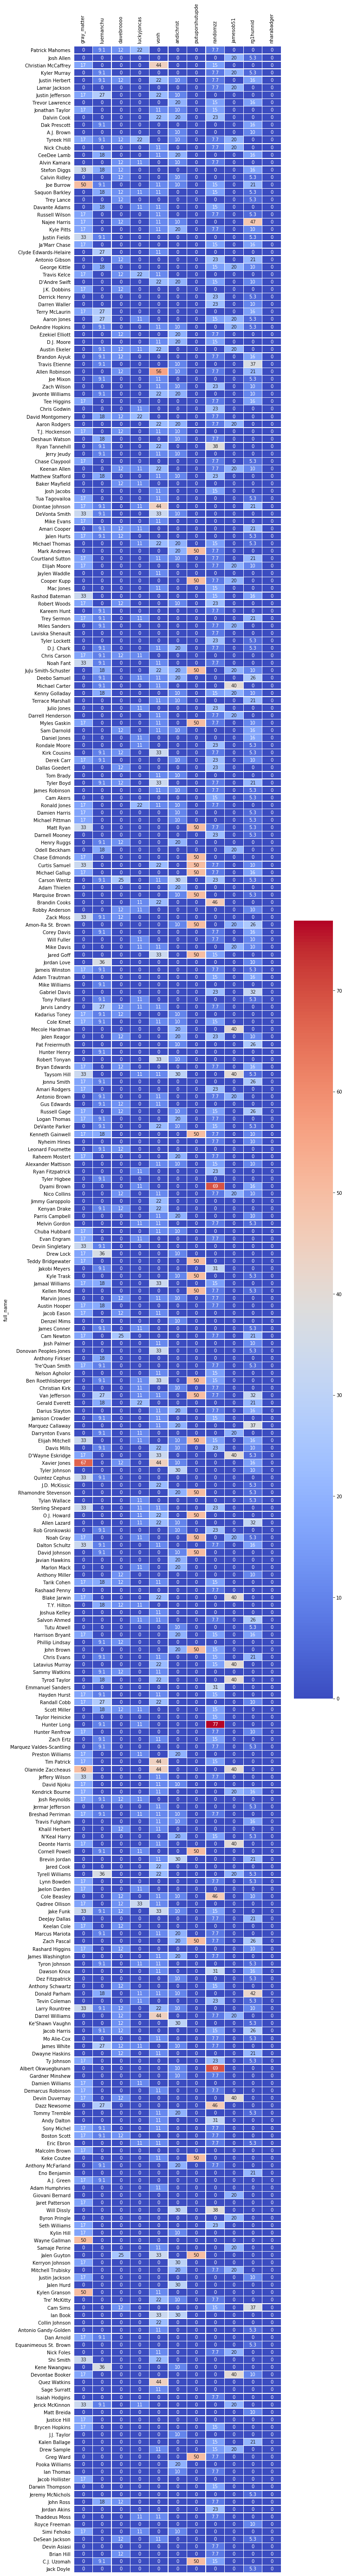

In [35]:
plt.rcParams['figure.figsize'] = (10, 100)
# pyplot.figure(figsize=(15, 10)) # width and height in inches
ax = sns.heatmap(df_tog, cmap='coolwarm', linewidth=0.4, annot=True,label='big')
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top
plt.xticks(rotation=90)
ax.set_xticks([i for i in ax.get_xticks()])
ax.tick_params(left=False, top=False)

plt.show()

In [36]:
ln = LEAGUE_NAME.replace(" ", "_")
viz_path = Path(f"{base_dir}/viz/")
viz_full_path = viz_path / f"{ln}_{USER_NAME}.pdf"

In [37]:
# sns.heatmap(df_tog, cmap='coolwarm', linewidth=0.4, annot=True,label='big').figure.savefig(f"/Users/glstream/Downloads/{USER_NAME}_{ln}_draft_ownership.pdf", dpi=300)


ax.figure.savefig(viz_full_path, dpi=300, bbox_inches='tight')

